In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import glob
import os
import itertools
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics

In [2]:
import tensorflow as tf

In [3]:
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.set_option('display.max_row', 10)
pd.set_option('display.float_format', '{:.1f}'.format)
sns.set_style('darkgrid')

In [4]:
# get the data via url
df = pd.read_csv('https://storage.googleapis.com/mledu-datasets/mnist_train_small.csv', sep = ',', header = None)
# randomly reindex the data frame
df = df.reindex(np.random.permutation(df.index))
# use just the first 10000 examples for training and validation
df = df.head(10000)

or could download the file to local directory using `curl`

```python
!curl -O https://storage.googleapis.com/mledu-datasets/mnist_train_small.csv
pd.read_cvs('mnist_train_small.csv', sep = ',')
```

## visualize some of the training sets

In [188]:
def random_glance(df, n = 9):
    '''
    Randomly select n number of examples to show their images
    '''
    row = int(math.sqrt(n))
    col = math.ceil(n/row)
    fig, axes = plt.subplots(row, col, dpi = 100)
    inds = np.random.choice(df.index, n)
    for ax in axes.ravel():
        n -= 1
        ax.set_xticks(())
        ax.set_yticks(())
        if n >=  0:
            ax.imshow(df.loc[inds[n], 1:].values.reshape(28, 28), interpolation = 'nearest', cmap = 'Greys')
            ax.set_title('Lable: %d' %df.loc[inds[n], 0])
        else:
            ax.imshow([[1]], cmap='gray', interpolation='nearest', vmin=0, vmax=1)
    plt.tight_layout()

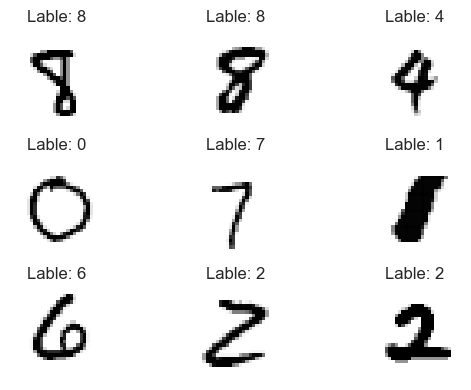

In [192]:
random_glance(df)

## Preprocess data

In [7]:
def preprocess(df):
    '''
    Parse the features and targets, and maybe feature scaling if needed
    '''
    labels = df[0]
    features = df.loc[:, 1:]
    features /= 255
    return features, labels

In [8]:
# Choose 7500 examples as our training set and remaining 2500 as validation set
training_set, training_targets = preprocess(df[:7500])
validation_set, validation_targets = preprocess(df[7500:])

## Construct scheme for training
Construct feature columns, input functions and training scheme

In [9]:
def construct_feature_columns():
    '''return a set of feature columns'''
    return set([tf.feature_column.numeric_column('pixels', shape = 784)])

In [118]:
def create_input_fn(features, labels = None, batch_size = 1, num_epochs = None, shuffle = True, training = True):
    '''
    Create input function for .train(), .predict(), etc.
    Returns a function that returns batches of features and labels
    '''
    if labels is None:
        labels = np.zeros(len(features))
    def _input_fn(num_epochs = None, shuffle = True, training = True):
        '''Input pipelines are reset with each call to .train(). To ensure model
        gets a good sampling of data, even when number of steps is small, we 
        shuffle all the data before creating the Dataset object
        '''
        if training:
            idx = np.random.permutation(features.index)
            raw_labels = np.array(labels[idx])
        else:
            num_epochs = 1
            idx = features.index
            raw_labels = labels.copy()
        raw_features = {'pixels': features.reindex(idx)}
        
        ds = Dataset.from_tensor_slices((raw_features, raw_labels))
        ds = ds.batch(batch_size).repeat(num_epochs)
        
        if training and shuffle:
            ds = ds.shuffle(10000)
            
        # return the next batch of data
        feature_batch, label_batch = ds.make_one_shot_iterator().get_next()
        return feature_batch, label_batch
    return lambda: _input_fn(training = training)

In [149]:
def train_classifier(classifier, steps, batch_size,
                             ts, tt, vs, vt, periods = 10):
    step_size = steps//periods
    
    training_input_fn = create_input_fn(ts, tt, batch_size, training = True)
    predict_input_fn = create_input_fn(ts, batch_size = batch_size, training = False)
    validation_input_fn = create_input_fn(vs, batch_size = batch_size, training = False)
    
    training_log_loss = []
    val_log_loss = []
    print('Training DNN regressor\nlog loss is:')

    for i in range(periods):
    # Because the training may take considerable amount of disk space, it's better to 
    # first use try and except to get out of the loop and do
    # _ = map(os.remove, glob.glob(os.path.join(logistic_classifier.model_dir, 
    # 'events.out.tfevents*'))) to save some space, especially when running on
    # laptops
        classifier.train(input_fn = training_input_fn,
                                 steps = step_size)
        predicts = list(classifier.predict(input_fn = predict_input_fn))
        probs = np.array([item['probabilities'] for item in predicts])
        pred_class = np.array([item['class_ids'][0] for item in predicts])
        pred_one_hot = tf.keras.utils.to_categorical(pred_class, 10)

        vals = list(classifier.predict(input_fn = validation_input_fn))
        val_probs = np.array([item['probabilities'] for item in vals])
        val_pred_class = np.array([item['class_ids'][0] for item in vals])
        val_pred_one_hot = tf.keras.utils.to_categorical(val_pred_class, 10)

        training_log_loss.append(metrics.log_loss(tt, pred_one_hot))
        val_log_loss.append(metrics.log_loss(vt, val_pred_one_hot))

        print('Preriods %d: training log loss ->%.2f, validation log loss -> %.2f ' 
              %(i, training_log_loss[-1], val_log_loss[-1]))
        
    print('Model training finished')
    # remove the event files from disk to save disk space
    _ = map(os.remove, glob.glob(os.path.join(classifier.model_dir, 'events.out.tfevents*')))
    
    final_predict = classifier.predict(input_fn = validation_input_fn)
    final_predict = np.array([item['class_ids'][0] for item in final_predict])
    
    accuracy = metrics.accuracy_score(vt, final_predict)
    print('Final accuracy on validation data: %.2f' %accuracy)
    
    fig = plt.figure(dpi = 100)
    plt.plot(training_log_loss, label = 'Training')
    plt.plot(val_log_loss, label = 'Validation')
    plt.legend()
    plt.xlabel('period')
    plt.ylabel('log loss')
    plt.tight_layout()
    
    fig = plt.figure(dpi = 100)
    conf_mat = metrics.confusion_matrix(vt, final_predict)
    conf_mat_norm = conf_mat.astype('float')/conf_mat.sum(axis = 1)[:, np.newaxis]
    ax = sns.heatmap(conf_mat_norm, cmap="bone_r")
    ax.set_aspect(1)
    plt.title("Confusion matrix")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()
    return classifier

## Build a logistic regressor
**use one-vs-all method to classifiy each digit**

In [140]:
my_optimizer = tf.train.AdagradOptimizer(learning_rate = 0.03)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
logistic_classifier = tf.estimator.LinearClassifier(
                    feature_columns = construct_feature_columns(),
                    n_classes = 10, optimizer = my_optimizer,
                    config=tf.estimator.RunConfig(keep_checkpoint_max=1))

Training DNN regressor
log loss is:
Preriods 0: training log loss ->3.88, validation log loss -> 4.42 
Preriods 1: training log loss ->3.53, validation log loss -> 3.97 
Preriods 2: training log loss ->3.27, validation log loss -> 3.92 
Preriods 3: training log loss ->2.98, validation log loss -> 3.65 
Preriods 4: training log loss ->3.14, validation log loss -> 3.70 
Preriods 5: training log loss ->2.88, validation log loss -> 3.65 
Preriods 6: training log loss ->2.78, validation log loss -> 3.45 
Preriods 7: training log loss ->2.79, validation log loss -> 3.51 
Preriods 8: training log loss ->2.67, validation log loss -> 3.56 
Preriods 9: training log loss ->2.57, validation log loss -> 3.33 
Model training finished
Final accuracy on validation data: 0.90


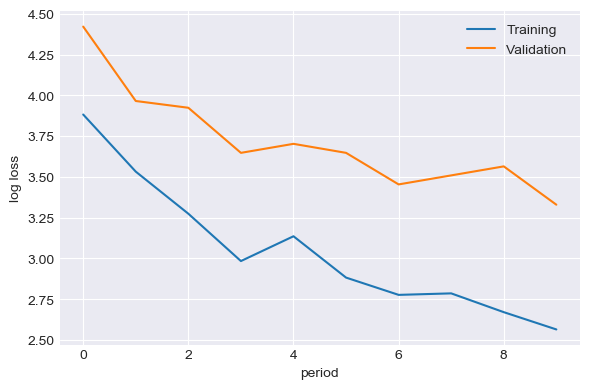

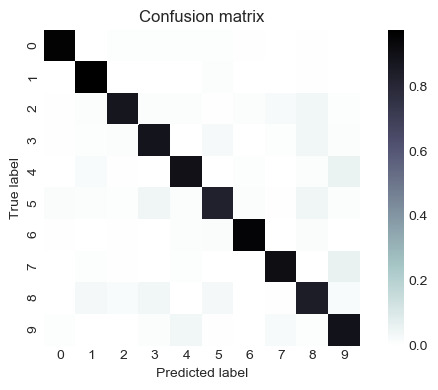

In [132]:
# the return classifier is the same with logistic_classifier
classifier = train_classifier(logistic_classifier, 1000, 30,
                            training_set, training_targets,
                            validation_set, validation_targets)

## Replace the Linear Classifier with a Neural Network
Use DNNClassifier to find a parameter combination that gives 0.95 or better accuracy

In [150]:
my_optimizer = tf.train.AdagradOptimizer(learning_rate = 0.03)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
hidden_units = [25, 10]
DNN_classifier = tf.estimator.DNNClassifier(feature_columns = construct_feature_columns(),
                                           hidden_units = hidden_units, n_classes = 10, optimizer = my_optimizer,
                                           config=tf.estimator.RunConfig(keep_checkpoint_max=1))

Training DNN regressor
log loss is:
Preriods 0: training log loss ->10.21, validation log loss -> 10.89 
Preriods 1: training log loss ->9.27, validation log loss -> 10.13 
Preriods 2: training log loss ->9.15, validation log loss -> 9.66 
Preriods 3: training log loss ->8.33, validation log loss -> 9.05 
Preriods 4: training log loss ->7.48, validation log loss -> 8.12 
Preriods 5: training log loss ->7.49, validation log loss -> 8.15 
Preriods 6: training log loss ->6.45, validation log loss -> 7.00 
Preriods 7: training log loss ->6.40, validation log loss -> 6.77 
Preriods 8: training log loss ->6.81, validation log loss -> 7.61 
Preriods 9: training log loss ->6.02, validation log loss -> 6.66 
Model training finished
Final accuracy on validation data: 0.81


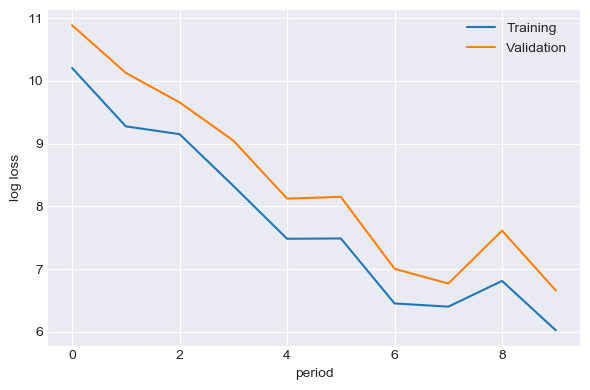

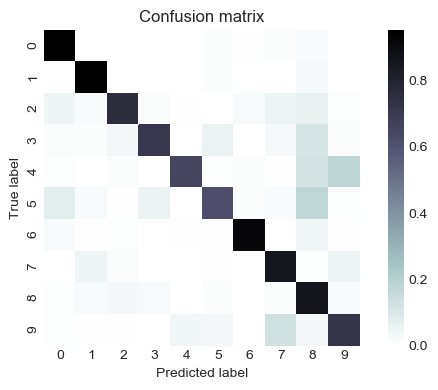

In [152]:
_ = train_classifier(DNN_classifier, 100, 10,
                    training_set, training_targets,
                    validation_set, validation_targets)

Training DNN regressor
log loss is:
Preriods 0: training log loss ->4.29, validation log loss -> 4.74 
Preriods 1: training log loss ->3.16, validation log loss -> 3.94 
Preriods 2: training log loss ->2.30, validation log loss -> 3.08 
Preriods 3: training log loss ->2.17, validation log loss -> 3.11 
Preriods 4: training log loss ->1.63, validation log loss -> 2.56 
Preriods 5: training log loss ->1.56, validation log loss -> 2.74 
Preriods 6: training log loss ->1.28, validation log loss -> 2.31 
Preriods 7: training log loss ->1.17, validation log loss -> 2.42 
Preriods 8: training log loss ->1.17, validation log loss -> 2.22 
Preriods 9: training log loss ->0.94, validation log loss -> 2.28 
Model training finished
Final accuracy on validation data: 0.93


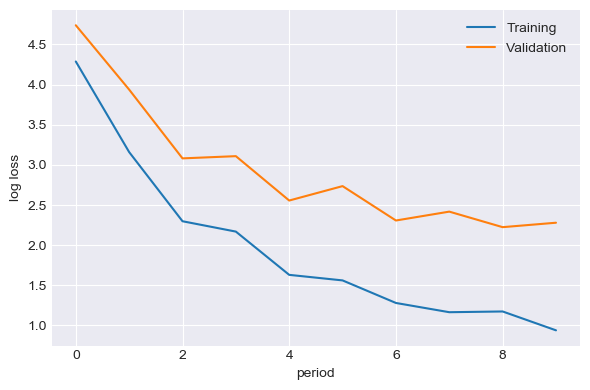

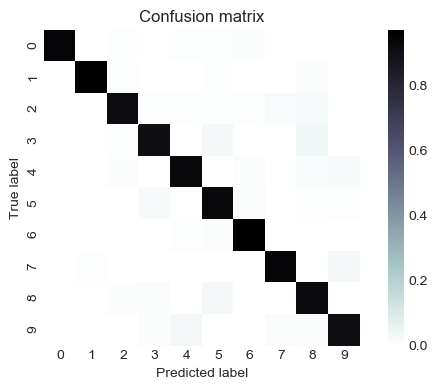

In [153]:
my_optimizer = tf.train.AdagradOptimizer(learning_rate = 0.03)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
hidden_units = [100, 100]
DNN_classifier = tf.estimator.DNNClassifier(feature_columns = construct_feature_columns(),
                                           hidden_units = hidden_units, n_classes = 10, optimizer = my_optimizer,
                                           config=tf.estimator.RunConfig(keep_checkpoint_max=1))
_ = train_classifier(DNN_classifier, 1000, 30,
                    training_set, training_targets,
                    validation_set, validation_targets)

Verify that on the test layer

In [154]:
test_df = pd.read_csv('https://storage.googleapis.com/mledu-datasets/mnist_test.csv', sep = ',', header = None)

In [156]:
test_set, test_targets = preprocess(test_df)
test_input_fn = create_input_fn(test_set, batch_size = batch_size, training = False)
pred_test = DNN_classifier.predict(input_fn = test_input_fn)
pred_test = np.array([item['class_ids'][0] for item in pred_test])
accuracy = metrics.accuracy_score(test_targets, pred_test)
print('Accuracy on the test data: %.2f' %accuracy)
pred_test = tf.keras.utils.to_categorical(pred_test, 10)
print('log loss on test set is %.2f' %metrics.log_loss(test_targets, pred_test))

Accuracy on the test data: 0.94
log loss on test set is 2.11


## Visualize the first hidden layers

In [199]:
def visualize_hidden(weights, n_pre = 28):
    '''
    n_pre: units from previous layer. For input layer n_pre is the number of pixels in a row
    '''
    n = weights.shape[1]
    rows = int(math.sqrt(n))
    cols = math.ceil(n/rows)
    fig, axes = plt.subplots(rows, cols, figsize = (3*rows, 3*cols), dpi = 100)
    for coef, ax in zip(weights.T, axes.ravel()):
        ax.imshow(coef.reshape(n_pix, n_pix), interpolation = 'nearest', cmap = 'Greys')
        ax.set_xticks(())
        ax.set_yticks(())
    plt.tight_layout()

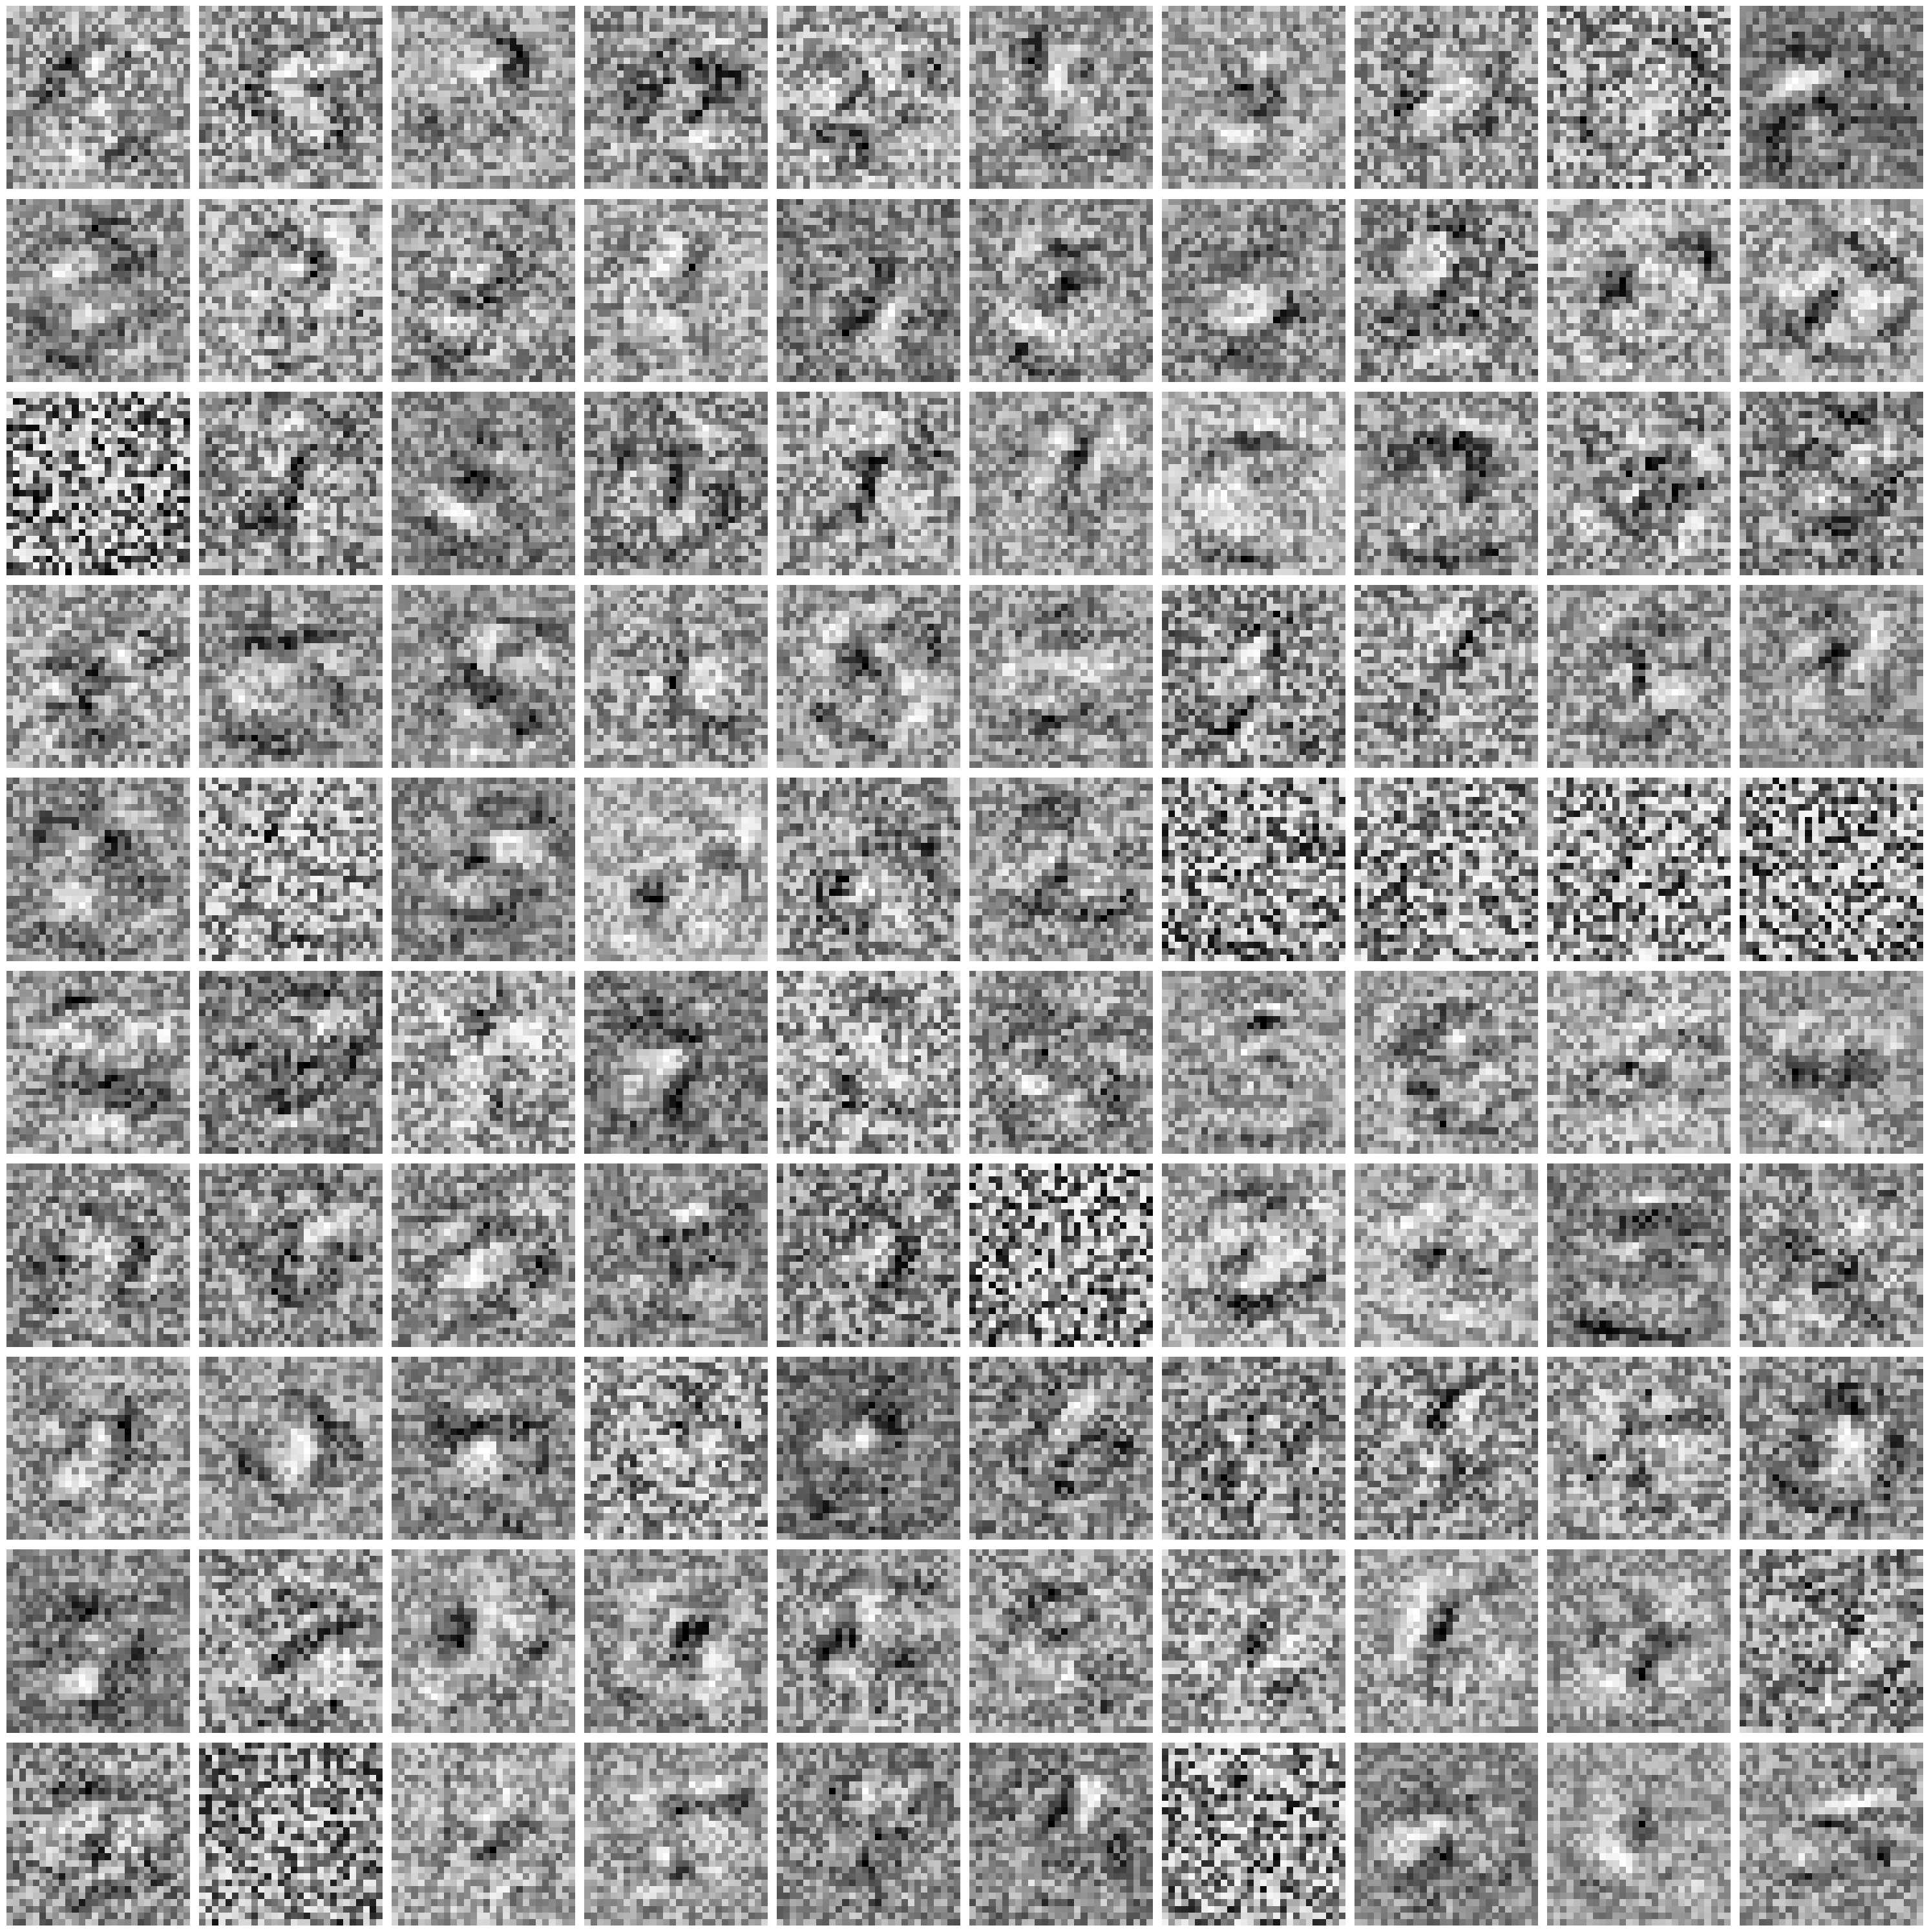

In [164]:
weights0 = DNN_classifier.get_variable_value('dnn/hiddenlayer_0/kernel')
visualize_hidden(weights0)

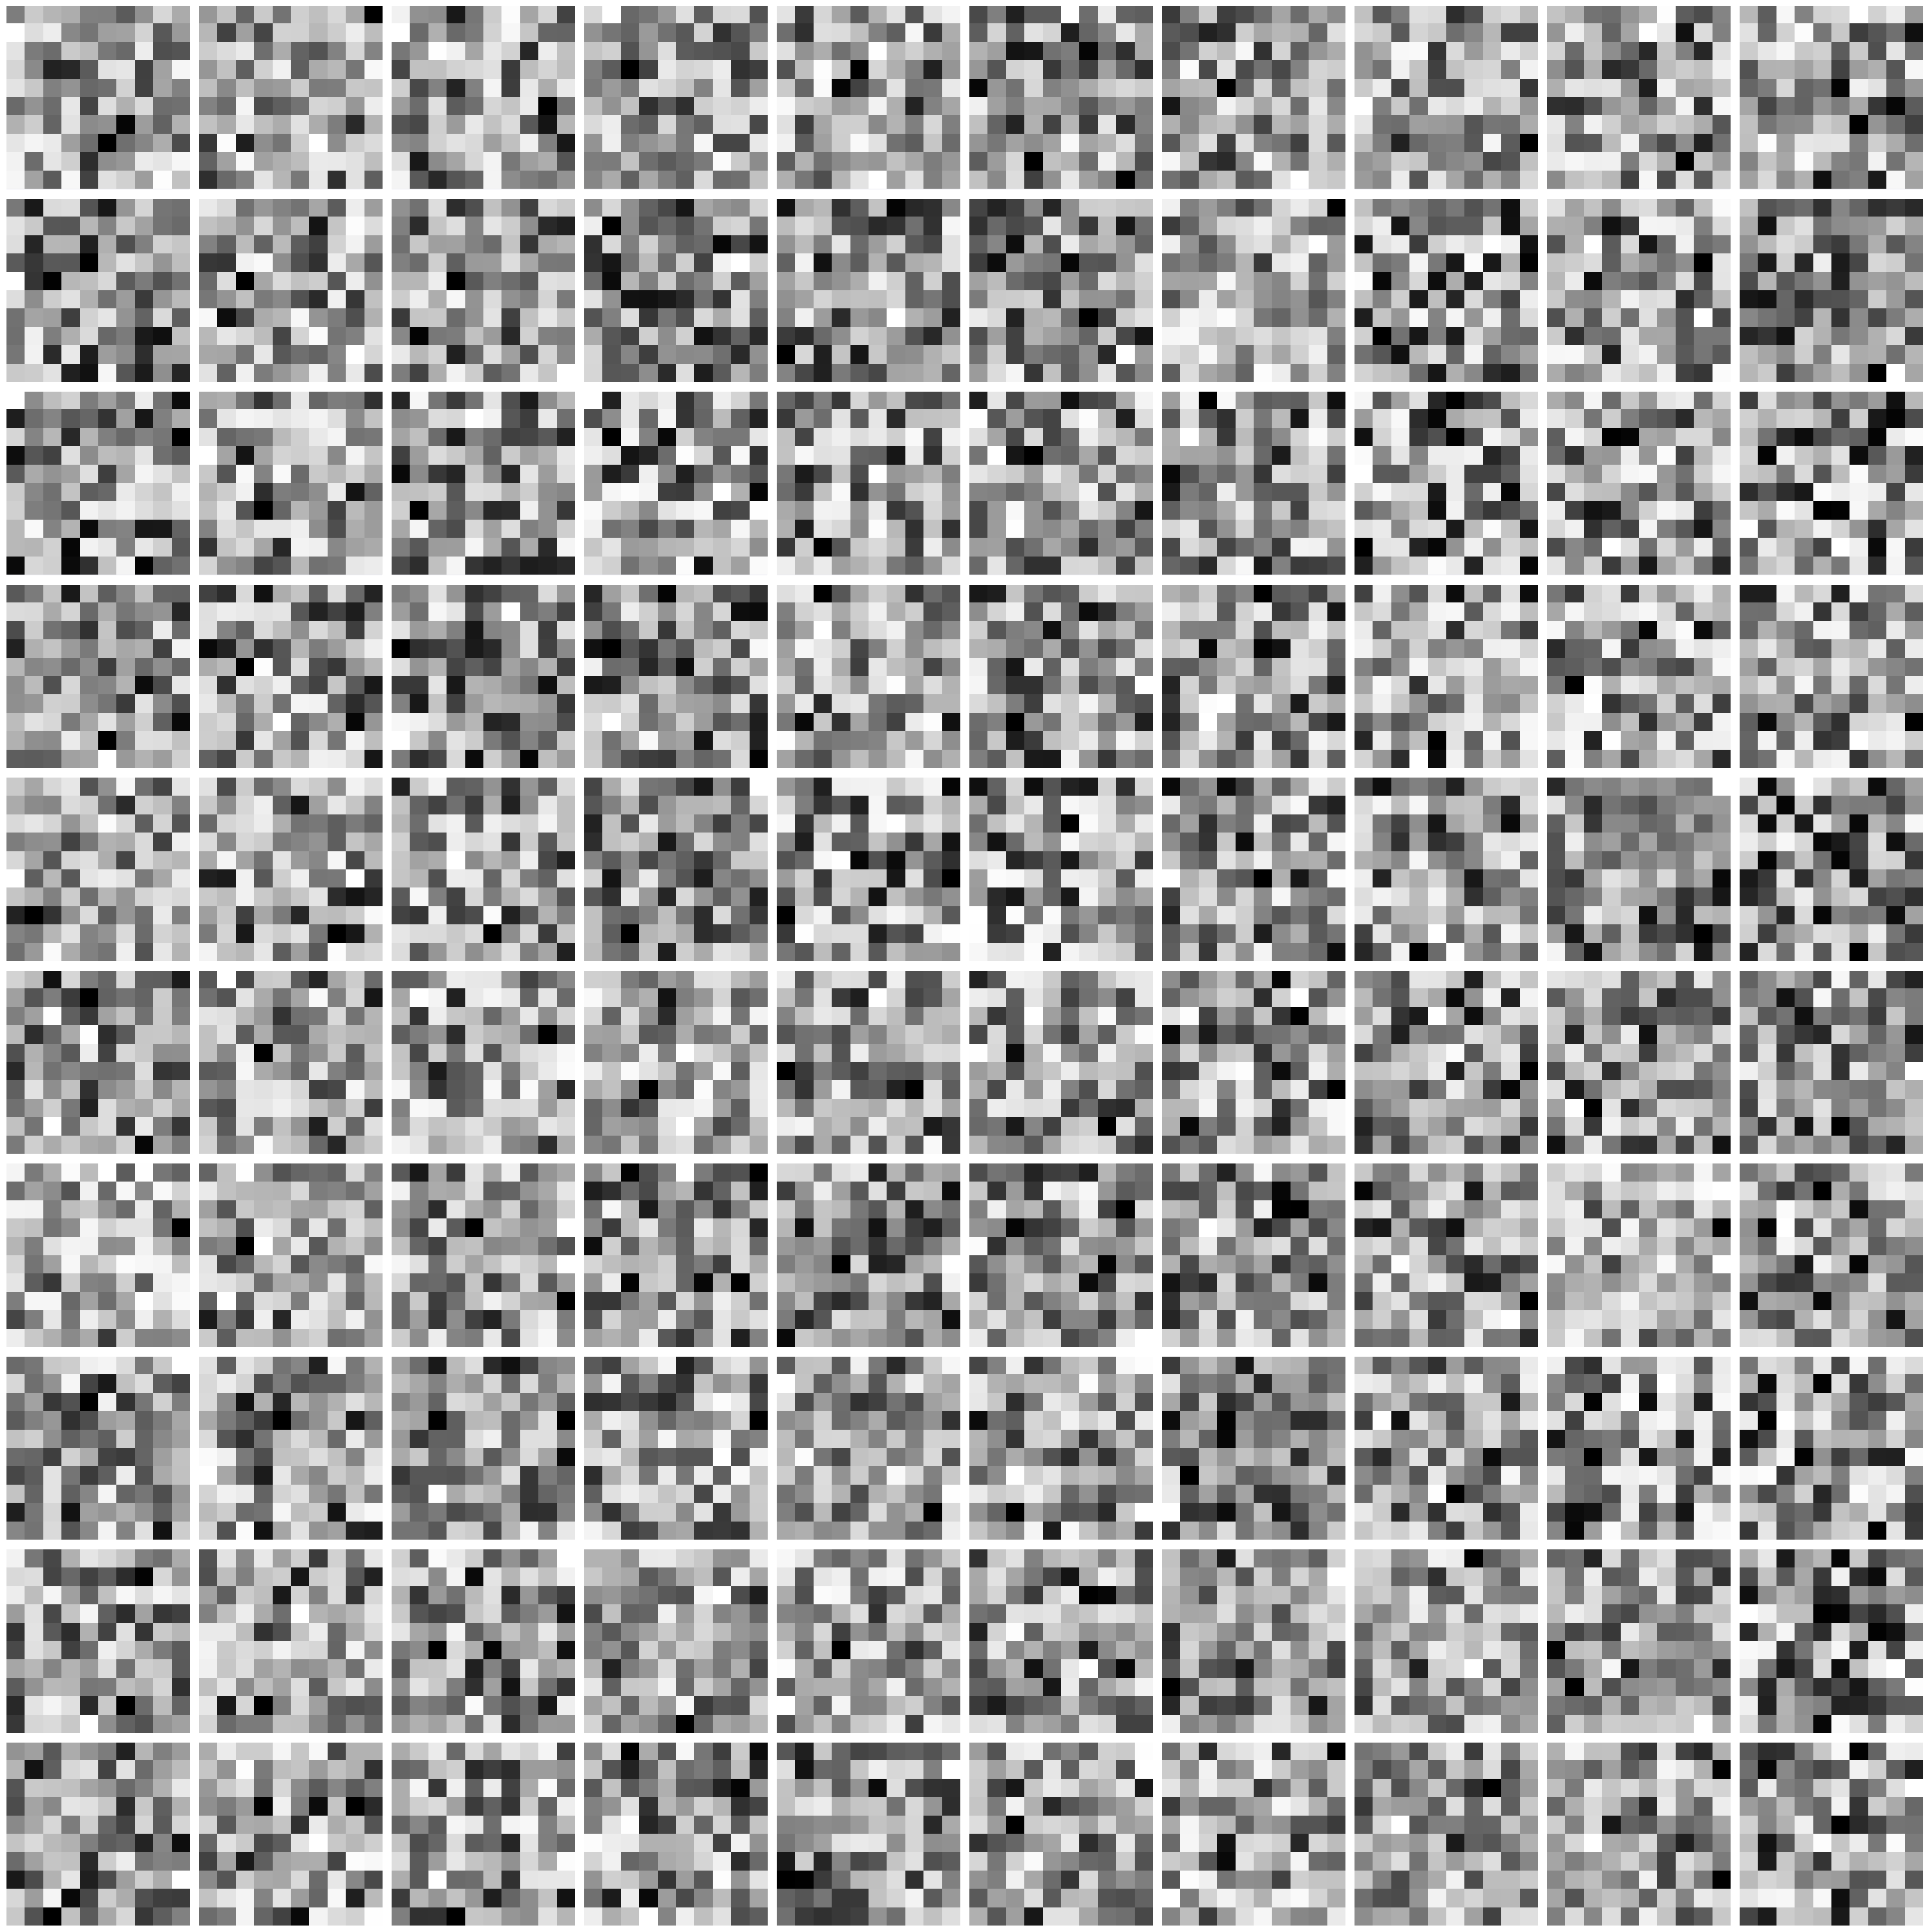

In [200]:
weights1 = DNN_classifier.get_variable_value('dnn/hiddenlayer_1/kernel')
visualize_hidden(weights1, 10)

The second hidden layer is less intuitive than first layer, maybe because it's for detail mining.

## Train the classifier for 100, 10 steps and see the convergence

Training DNN regressor
log loss is:
Preriods 0: training log loss ->17.17, validation log loss -> 17.03 
Preriods 1: training log loss ->12.16, validation log loss -> 12.12 
Preriods 2: training log loss ->9.01, validation log loss -> 9.45 
Preriods 3: training log loss ->5.83, validation log loss -> 5.94 
Preriods 4: training log loss ->6.16, validation log loss -> 6.60 
Preriods 5: training log loss ->4.32, validation log loss -> 4.68 
Preriods 6: training log loss ->4.96, validation log loss -> 5.32 
Preriods 7: training log loss ->4.50, validation log loss -> 4.89 
Preriods 8: training log loss ->4.32, validation log loss -> 4.75 
Preriods 9: training log loss ->3.80, validation log loss -> 4.34 
Model training finished
Final accuracy on validation data: 0.87


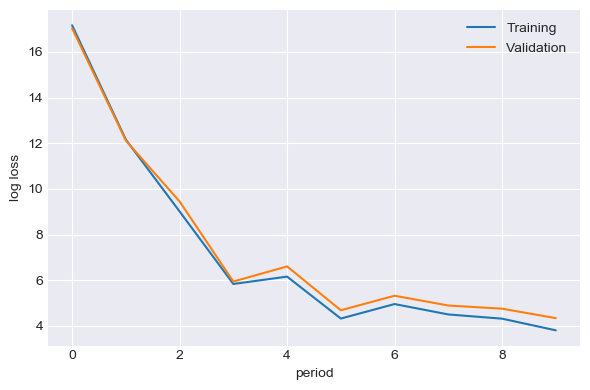

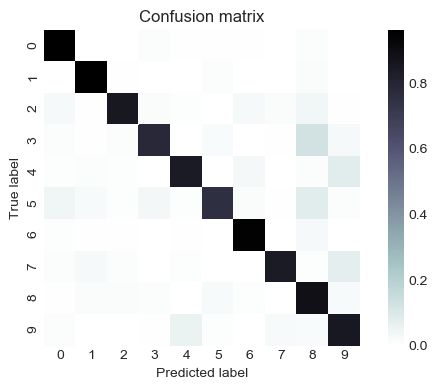

In [201]:
DNN_classifier = tf.estimator.DNNClassifier(feature_columns = construct_feature_columns(),
                                           hidden_units = hidden_units, n_classes = 10, optimizer = my_optimizer,
                                           config=tf.estimator.RunConfig(keep_checkpoint_max=1))
_ = train_classifier(DNN_classifier, 100, 30,
                    training_set, training_targets,
                    validation_set, validation_targets)

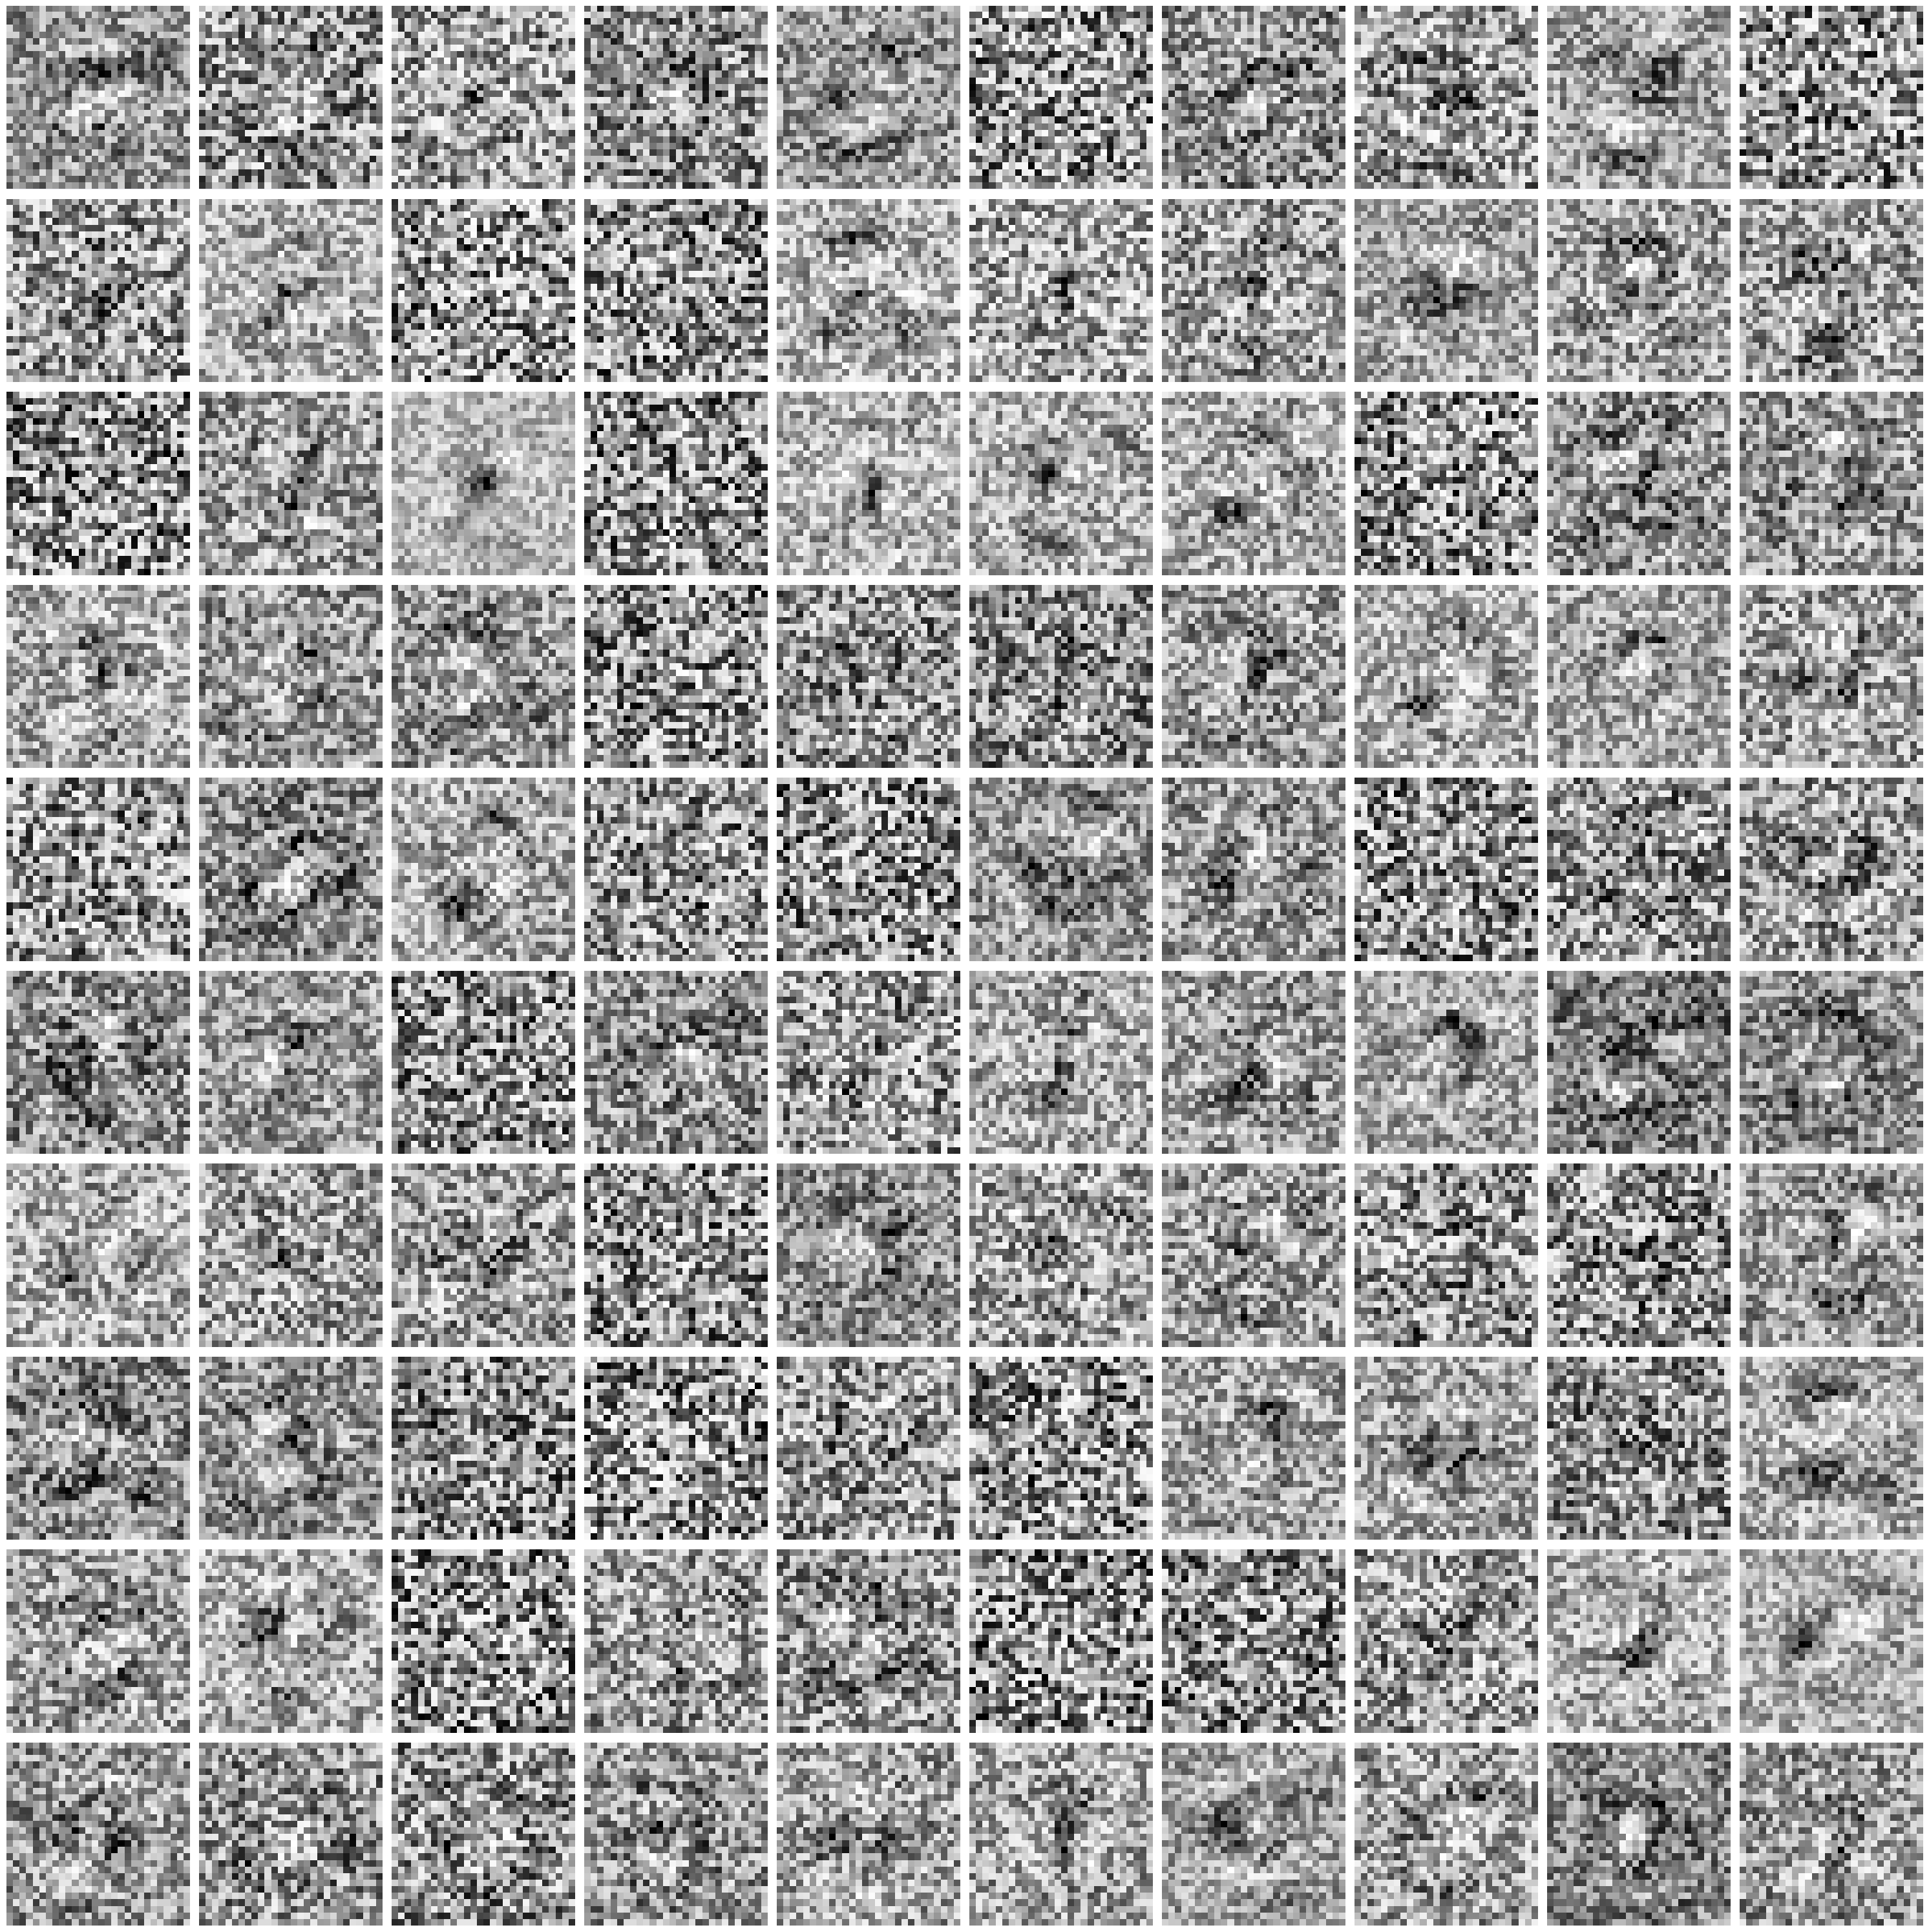

In [202]:
weights0 = DNN_classifier.get_variable_value('dnn/hiddenlayer_0/kernel')
visualize_hidden(weights0)

Training DNN regressor
log loss is:
Preriods 0: training log loss ->26.78, validation log loss -> 27.06 
Preriods 1: training log loss ->27.11, validation log loss -> 27.63 
Preriods 2: training log loss ->22.87, validation log loss -> 23.58 
Preriods 3: training log loss ->22.78, validation log loss -> 23.06 
Preriods 4: training log loss ->21.00, validation log loss -> 21.90 
Preriods 5: training log loss ->20.10, validation log loss -> 20.74 
Preriods 6: training log loss ->16.76, validation log loss -> 16.84 
Preriods 7: training log loss ->16.31, validation log loss -> 16.39 
Preriods 8: training log loss ->17.53, validation log loss -> 18.03 
Preriods 9: training log loss ->13.70, validation log loss -> 14.46 
Model training finished
Final accuracy on validation data: 0.58


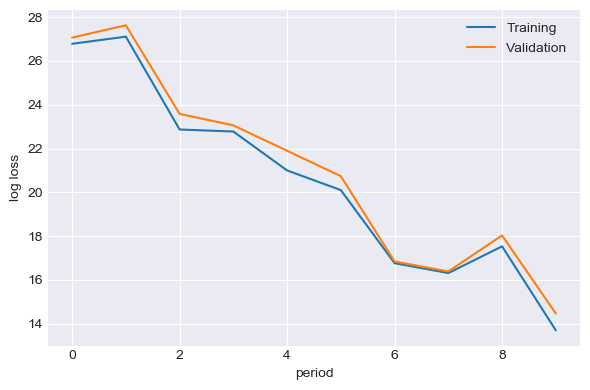

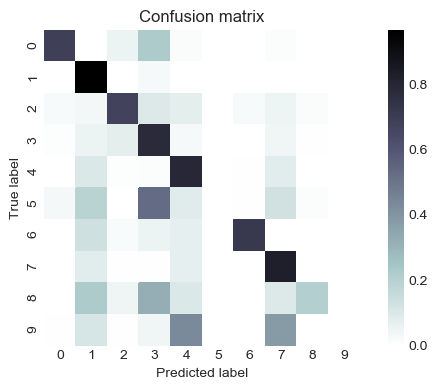

In [203]:
DNN_classifier = tf.estimator.DNNClassifier(feature_columns = construct_feature_columns(),
                                           hidden_units = hidden_units, n_classes = 10, optimizer = my_optimizer,
                                           config=tf.estimator.RunConfig(keep_checkpoint_max=1))
_ = train_classifier(DNN_classifier, 10, 30,
                    training_set, training_targets,
                    validation_set, validation_targets)

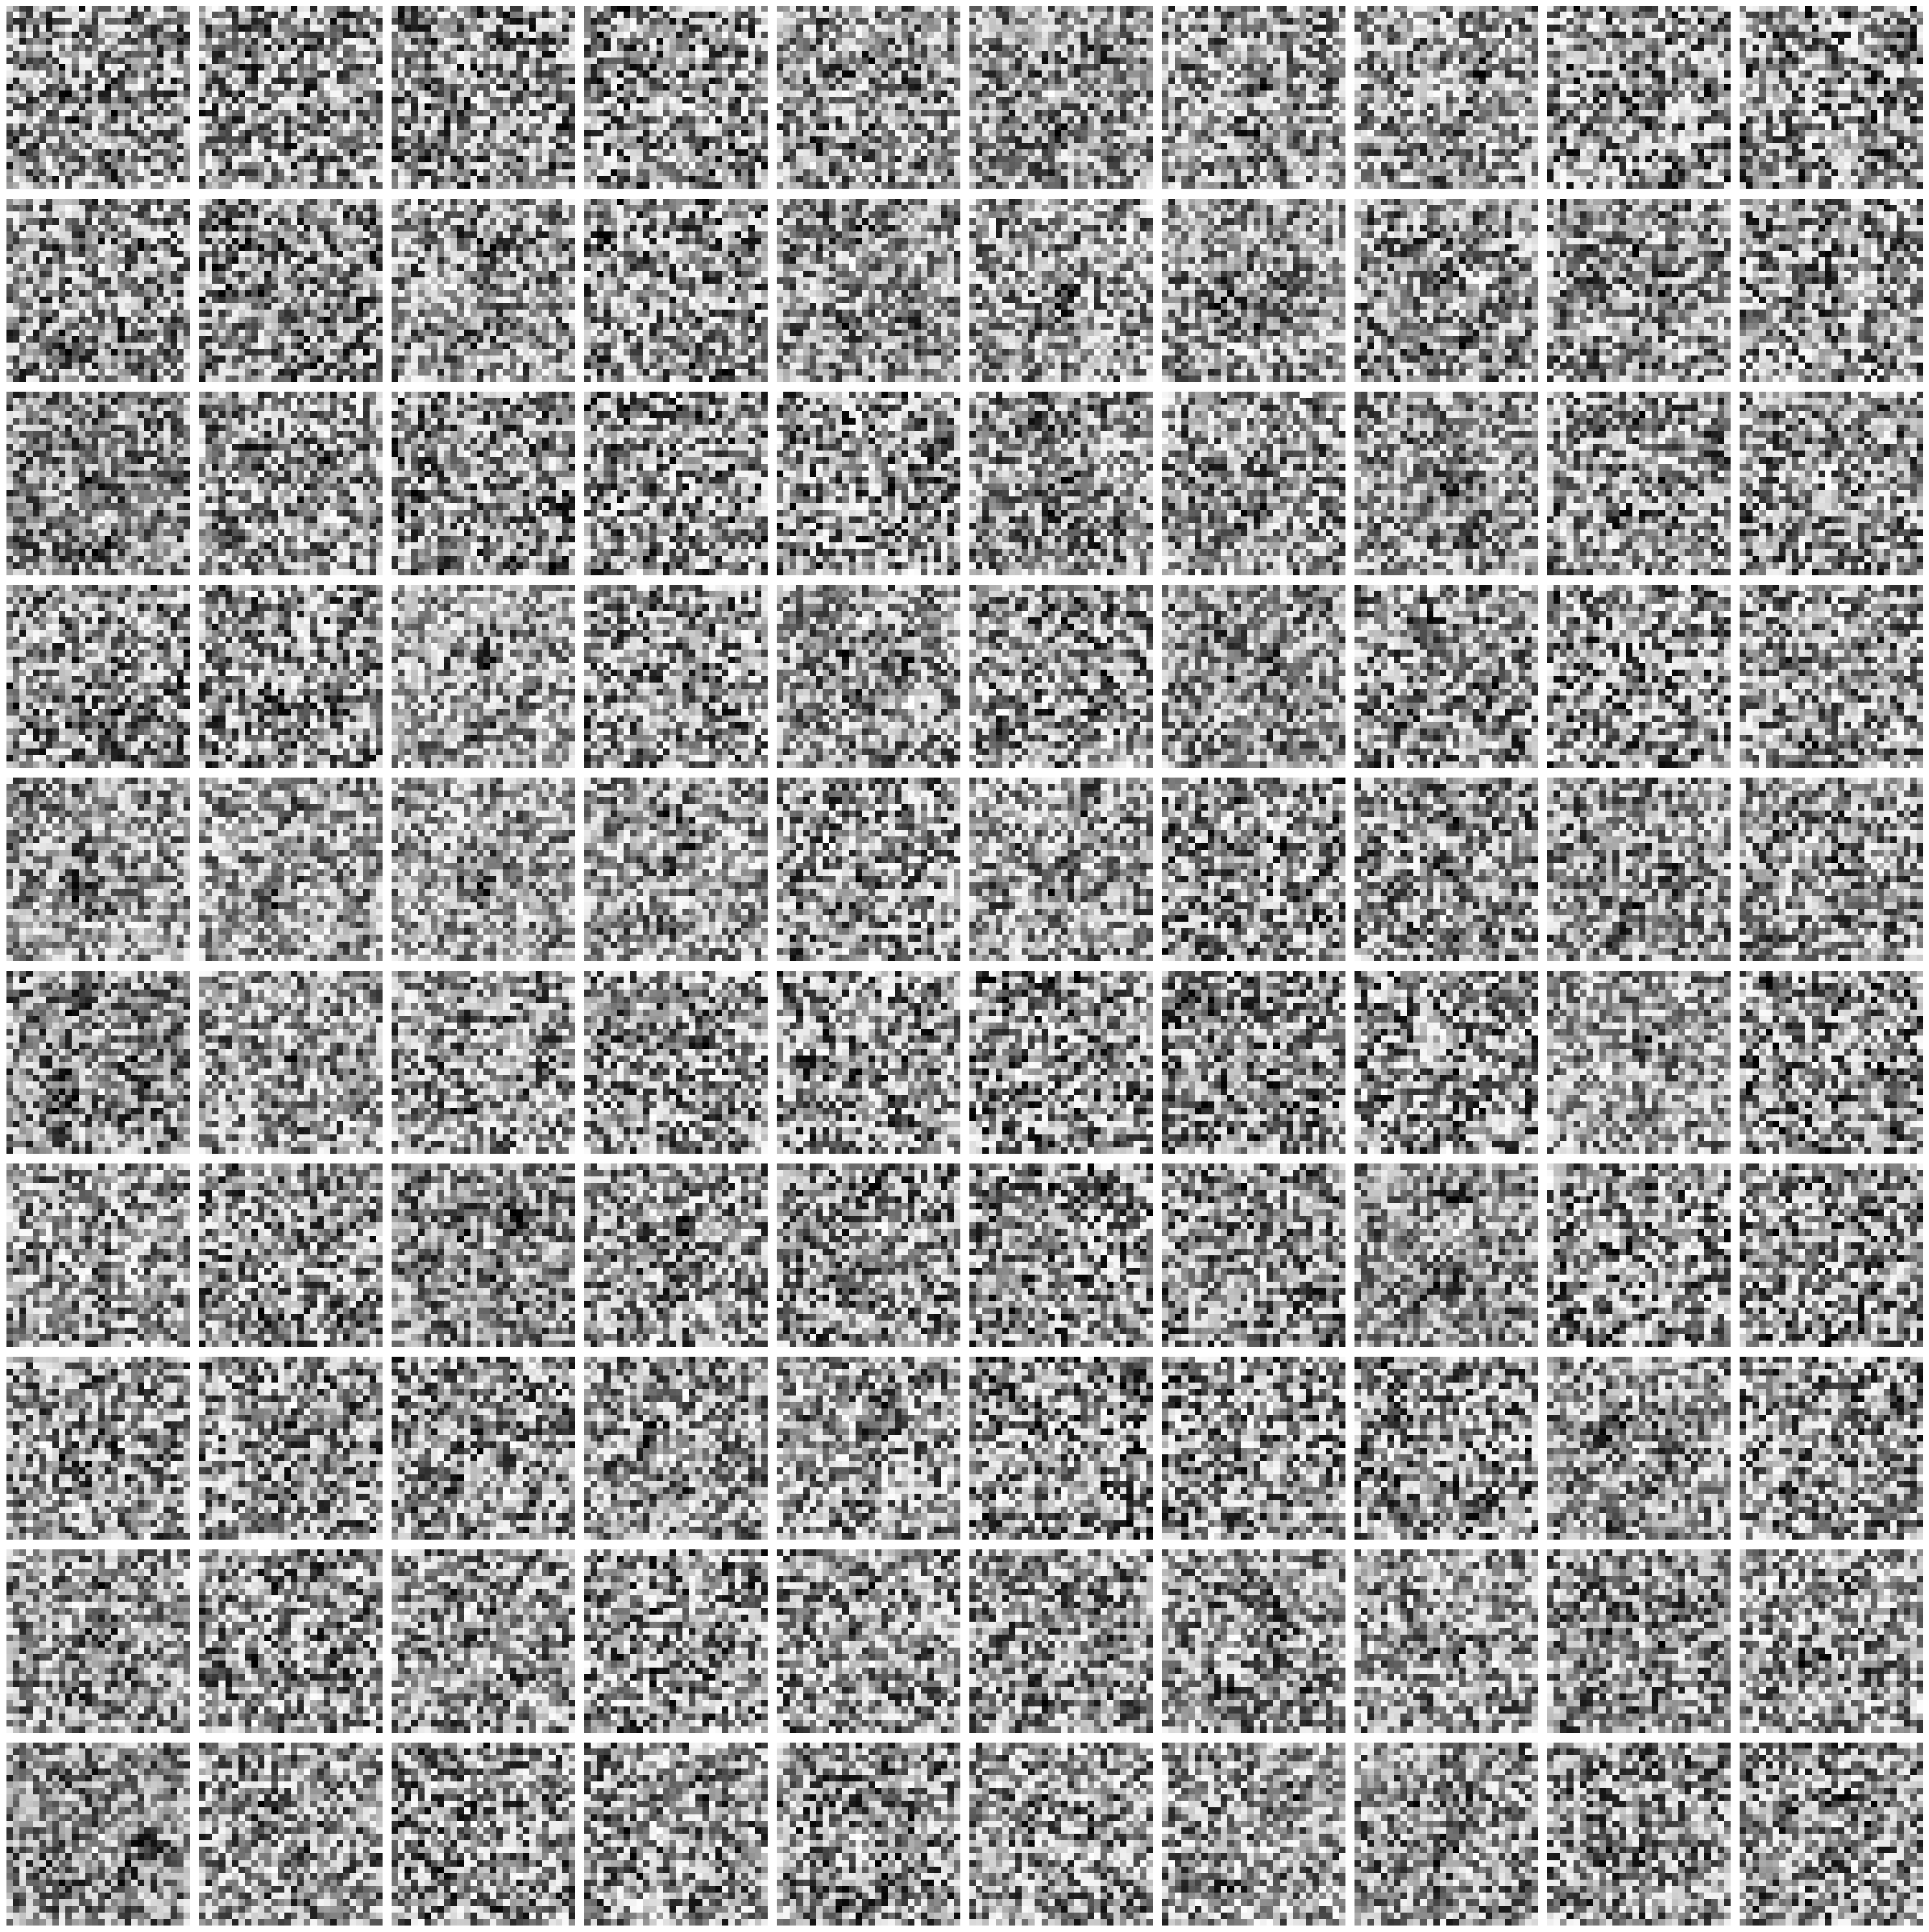

In [204]:
weights0 = DNN_classifier.get_variable_value('dnn/hiddenlayer_0/kernel')
visualize_hidden(weights0)